<html>
<head>
	<title></title>
</head>
<body>
<h1 style="text-align: center;line-height: 120%;">ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ НАЦИОНАЛЬНЫЙ ИССЛЕДОВАТЕЛЬСКИЙ УНИВЕРСИТЕТ «МОСКОВСКИЙ ЭНЕРГЕТИЧЕСКИЙ ИНСТИТУТ» Кафедра «РЗиАЭ»</h1>
<h2 style="text-align: center;line-height: 20%;">Лабораторная работа №4</h2>

<h3 style="text-align: center;line-height: 80%;"><em>ГЛУБОКОЕ ОБУЧЕНИЕ ДЛЯ ПРОГНОЗИРОВАНИЯ
ВРЕМЕННОГО РЯДА </em></h3>
    
<h3 style="text-align: center;line-height: 60%;"><em>по дисциплине: "Применение методов искусственного интеллекта в электроэнергетике"   </em></h3>

    
<p style="text-align: right;line-height: 40%;"> Выполнил: студент группы Э-13м-19</p>

<p style="text-align: right;line-height: 40%;">Антонов И.И.</p>

<p style="text-align: right;line-height: 40%;">Принял: Нухулов С.М.</p>
<h4 style="text-align: center;line-height: 100%;"><em> Москва, 2020</em></h3>
</body>
</html>

## Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Flatten, Dense, Conv1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import GRU 

## Пункт 1

In [3]:
data = pd.read_csv('AEP_hourly.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


## Пункт 2

In [4]:
data.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [397]:
train_shape = int(data['AEP_MW'].shape[0]*0.6)
mean = data['AEP_MW'][:train_shape].mean(axis = 0)
std = data['AEP_MW'][:train_shape].std(axis = 0)
data['AEP_MW'] = data['AEP_MW'].apply(lambda x: (x - mean) / std)

## Пункт 3
- количество выборок в прошлом, которое определяет окно
    временного ряда, являющееся признаковым описанием объекта
    (lookback);
    
- количество выборок в будущем, которое определяет окно
    временного ряда, являющееся целевым значением (delay);
    
- два индекса массива входных данных, ограничивающих область
    извлечения данных (min_index, max_index);
    
- параметр, определяющий, будет ли производиться формирование
    окон в случайном порядке или последовательно (shuffle);
    
- количество окон в пакете данных (batch_size); 

- шаг формирования окон из исходного временного ряда (step)

In [501]:
def generator(data, lookback, delay, min_index, max_index,
             shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            # Если превысили макс. индекс строк
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows) 
        #print(f'rows\n{rows}')
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        #print(f'samples shape: {samples.shape}')
        targets = np.zeros((len(rows),))
        #print(f'targets:\n{targets}')
        
        # enumerate генерирует кортеж - (индекс элемента, элемент)
        for j, row in enumerate(rows):
            #print(f'j: {j}, row: {row}')
            indices = range(rows[j] - lookback, rows[j], step)
            #print(f'indices: {indices}')
            samples[j] = data[indices]
            #print(f'samples[{j}] : {samples[j]}')
            targets[j] = data[rows[j] + delay][0]
            #print(f'targets[{j}] : {targets[j]}')
        yield samples, targets

## Пункт 4

In [502]:
train_gen = generator(np.asarray(data.drop(columns=['Datetime'], axis=1)),
                     lookback=168,
                     delay=6,
                     min_index=0,
                     max_index=int(data['AEP_MW'].shape[0]*0.6),
                     shuffle=True,
                     step=1,
                     batch_size=144)

val_gen = generator(np.asarray(data.drop(columns=['Datetime'], axis=1)),
                   lookback=168,
                   delay=6,
                   min_index=int(data['AEP_MW'].shape[0]*0.6) + 1,
                   max_index=int(data['AEP_MW'].shape[0]*0.8),
                   step=1,
                   batch_size=144)

test_gen = generator(np.asarray(data.drop(columns=['Datetime'], axis=1)),
                    lookback=168,
                    delay=6,
                    min_index=int(data['AEP_MW'].shape[0]*0.8) + 1,
                    max_index=data['AEP_MW'].shape[0],
                    step=1,
                    batch_size=144)

## Пункт 5

In [503]:
test_package = (data['AEP_MW'].shape[0] - int(data['AEP_MW'].shape[0]*0.8) + 1 - 168) // 144

In [504]:
samples_series = []
targets_series = []
for step in range(test_package):
        samples, targets = next(test_gen)
        targets_series.append(targets)
        samples_series.append(samples[:, -1, 0])

In [505]:
test_true = np.asarray(targets_series).reshape(144 * test_package)

In [403]:
def calculate_ME(samples, targets):
    mes = []
    for i in range(len(samples)):
        me = np.mean(samples[i] - targets[i])
        mes.append(me)
    return np.mean(mes)

In [404]:
def calculate_MAE(samples, targets):
    mes = []
    for i in range(len(samples)):
        mae = np.mean(np.abs(samples[i] - targets[i]))
        mes.append(mae)
    return np.mean(mes)

In [405]:
print(f'ME: {calculate_ME(samples_series, targets_series) * std:1.3f}')
print(f'MAE: {calculate_MAE(samples_series, targets_series) * std:1.3f}')

ME: -0.803
MAE: 2161.788


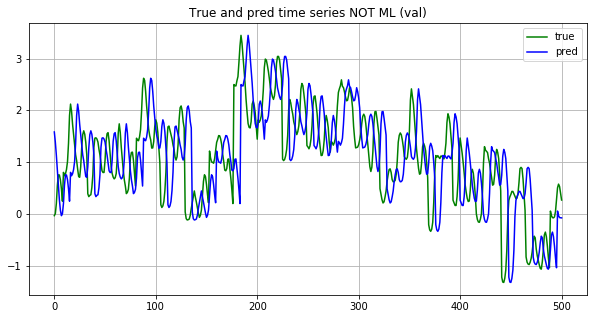

ME: -0.803
MAE: 2161.788


In [406]:
x = np.linspace(0,500,500,dtype=int)
plt.figure(figsize=(10,5))
plt.plot(x, np.asarray(targets_series).reshape(144 * val_package)[:500], 'g-')
plt.plot(x, np.asarray(samples_series).reshape(144 * val_package)[:500], 'b-')
plt.title('True and pred time series NOT ML (val)')
plt.legend(['true','pred'],loc='upper right')
plt.grid()
plt.show()
print(f'ME: {calculate_ME(samples_series, targets_series) * std:1.3f}')
print(f'MAE: {calculate_MAE(samples_series, targets_series) * std:1.3f}')

## Пункт 6

In [367]:
NN = Sequential([
    Flatten(input_shape=(168, 1)),
    Dense(32, input_shape = (168, 1), activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(8, activation = 'relu'),
    Dense(1),
])
NN.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 168)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 32)                5408      
_________________________________________________________________
dense_24 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 9         
Total params: 6,081
Trainable params: 6,081
Non-trainable params: 0
_________________________________________________________________


In [368]:
NN.compile(optimizer=RMSprop(), loss='mae')
history = NN.fit_generator(train_gen,
                            steps_per_epoch=506,
                            epochs=13,
                            validation_data=val_gen,
                            validation_steps=val_package)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 506 steps, validate for 167 steps
Epoch 1/13
506/506 [==============================] - 4s 7ms/step - loss: 0.3006 - val_loss: 0.2554
Epoch 2/13
506/506 [==============================] - 3s 6ms/step - loss: 0.2371 - val_loss: 0.2364
Epoch 3/13
506/506 [==============================] - 3s 6ms/step - loss: 0.2227 - val_loss: 0.2248
Epoch 4/13
506/506 [==============================] - 3s 6ms/step - loss: 0.2129 - val_loss: 0.2202
Epoch 5/13
506/506 [==============================] - 3s 6ms/step - loss: 0.2093 - val_loss: 0.2152
Epoch 6/13
506/506 [==============================] - 3s 6ms/step - loss: 0.2035 - val_loss: 0.2095
Epoch 7/13
506/506 [==============================] - 3s 6ms/step - loss: 0.1994 - val_loss: 0.2088
Epoch 8/13
506/506 [==============================] - 3s 6ms/step - loss: 0.1983 - val_loss: 0.2063
Epoch 9/13
506/506 [==============================] - 3s 6ms/step - loss: 0.1948 - val_loss: 0.2080
Epoch 

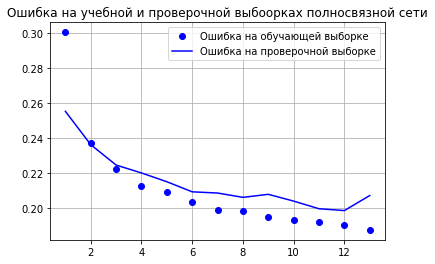

In [369]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Ошибка на обучающей выборке')
plt.grid(True)
plt.plot(epochs, val_loss, 'b', label='Ошибка на проверочной выборке')
plt.title('Ошибка на учебной и проверочной выбоорках полносвязной сети')
plt.legend()
plt.show()

In [431]:
test_predict = NN.predict_generator(test_gen, test_package)

In [432]:
print(f'ME: {calculate_ME(test_predict, test_true) * std:1.3f}')
print(f'MAE: {calculate_MAE(test_predict, test_true) * std:1.3f}')

ME: 156.133
MAE: 575.663


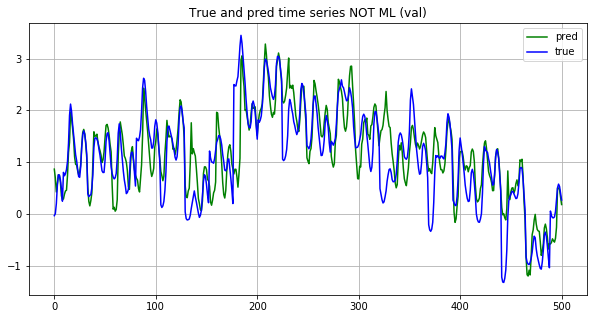

In [433]:
x = np.linspace(0,500,500,dtype=int)
plt.figure(figsize=(10,5))
plt.plot(x, test_predict[:500], 'g-')
plt.plot(x, test_true[:500], 'b-')
plt.title('True and pred time series NOT ML (val)')
plt.legend(['pred','true'],loc='upper right')
plt.grid()
plt.show()

## Пункт 7

In [377]:
CN = Sequential([
    Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(168, 1)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(15, activation='relu'),
    Dense(1),
])
CN.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 166, 16)           64        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 164, 32)           1568      
_________________________________________________________________
flatten_8 (Flatten)          (None, 5248)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                167968    
_________________________________________________________________
dense_31 (Dense)             (None, 15)                495       
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 16        
Total params: 170,111
Trainable params: 170,111
Non-trainable params: 0
_______________________________________________

In [379]:
CN.compile(optimizer=RMSprop(), loss='mae')
history = CN.fit_generator(train_gen,                 
                             steps_per_epoch=506,    
                             epochs=15,                            
                             validation_data=val_gen,       
                             validation_steps=test_package)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 506 steps, validate for 167 steps
Epoch 1/20
506/506 [==============================] - 7s 14ms/step - loss: 0.2928 - val_loss: 0.2612
Epoch 2/20
506/506 [==============================] - 7s 14ms/step - loss: 0.2261 - val_loss: 0.2120
Epoch 3/20
506/506 [==============================] - 7s 14ms/step - loss: 0.2058 - val_loss: 0.2176
Epoch 4/20
506/506 [==============================] - 8s 16ms/step - loss: 0.1916 - val_loss: 0.2225
Epoch 5/20
506/506 [==============================] - 8s 16ms/step - loss: 0.1837 - val_loss: 0.2151
Epoch 6/20
506/506 [==============================] - 8s 17ms/step - loss: 0.1768 - val_loss: 0.1801
Epoch 7/20
506/506 [==============================] - 8s 16ms/step - loss: 0.1740 - val_loss: 0.1860
Epoch 8/20
506/506 [==============================] - 8s 16ms/step - loss: 0.1682 - val_loss: 0.1810
Epoch 9/20
506/506 [==============================] - 8s 16ms/step - loss: 0.1640 - val_loss: 0.19

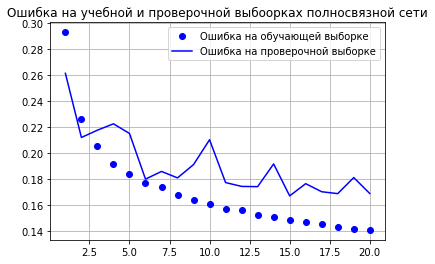

In [380]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Ошибка на обучающей выборке')
plt.grid(True)
plt.plot(epochs, val_loss, 'b', label='Ошибка на проверочной выборке')
plt.title('Ошибка на учебной и проверочной выбоорках полносвязной сети')
plt.legend()
plt.show()

In [436]:
test_predict = CN.predict_generator(test_gen, test_package)

In [437]:
print(f'ME: {calculate_ME(test_predict, test_true) * std:1.3f}')
print(f'MAE: {calculate_MAE(test_predict, test_true) * std:1.3f}')

ME: -69.553
MAE: 481.251


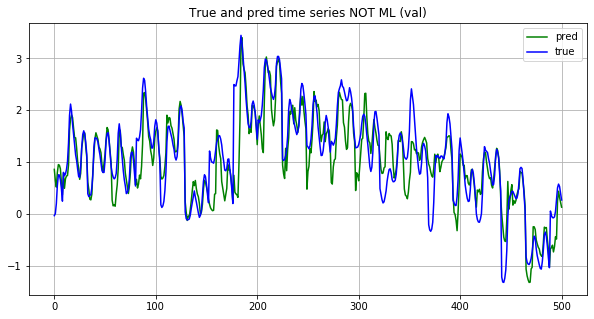

In [438]:
x = np.linspace(0,500,500,dtype=int)
plt.figure(figsize=(10,5))
plt.plot(x, test_predict[:500], 'g-')
plt.plot(x, test_true[:500], 'b-')
plt.title('True and pred time series NOT ML (val)')
plt.legend(['pred','true'],loc='upper right')
plt.grid()
plt.show()

## Пункт 8

In [461]:
RN = Sequential()
RN.add(GRU(32, input_shape = (None, 1))) 
RN.add(Dense(1))
RN.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 32)                3360      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [462]:
RN.compile(optimizer=RMSprop(), loss='mae')
history = RN.fit_generator(train_gen,                 
                             steps_per_epoch=506,    
                             epochs=12,                            
                             validation_data=val_gen,       
                             validation_steps=test_package)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 506 steps, validate for 167 steps
Epoch 1/15
506/506 [==============================] - 43s 85ms/step - loss: 0.5175 - val_loss: 0.4130
Epoch 2/15
506/506 [==============================] - 42s 83ms/step - loss: 0.4047 - val_loss: 0.3780
Epoch 3/15
506/506 [==============================] - 43s 84ms/step - loss: 0.3536 - val_loss: 0.3360
Epoch 4/15
506/506 [==============================] - 43s 85ms/step - loss: 0.3240 - val_loss: 0.3022
Epoch 5/15
506/506 [==============================] - 43s 84ms/step - loss: 0.2983 - val_loss: 0.2908
Epoch 6/15
506/506 [==============================] - 43s 85ms/step - loss: 0.2805 - val_loss: 0.2798
Epoch 7/15
506/506 [==============================] - 44s 86ms/step - loss: 0.2661 - val_loss: 0.2790
Epoch 8/15
506/506 [==============================] - 44s 86ms/step - loss: 0.2579 - val_loss: 0.3088
Epoch 9/15
506/506 [==============================] - 44s 87ms/step - loss: 0.2488 - val_l

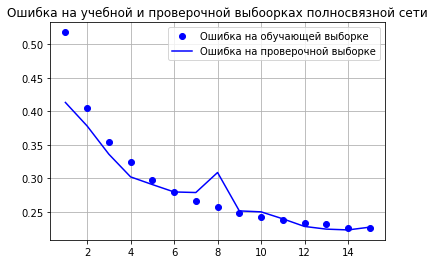

In [463]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Ошибка на обучающей выборке')
plt.grid(True)
plt.plot(epochs, val_loss, 'b', label='Ошибка на проверочной выборке')
plt.title('Ошибка на учебной и проверочной выбоорках полносвязной сети')
plt.legend()
plt.show()

In [474]:
test_predict = RN.predict_generator(test_gen, test_package)

In [475]:
print(f'ME: {calculate_ME(test_predict, test_true) * std:1.3f}')
print(f'MAE: {calculate_MAE(test_predict, test_true) * std:1.3f}')

ME: 194.241
MAE: 641.318


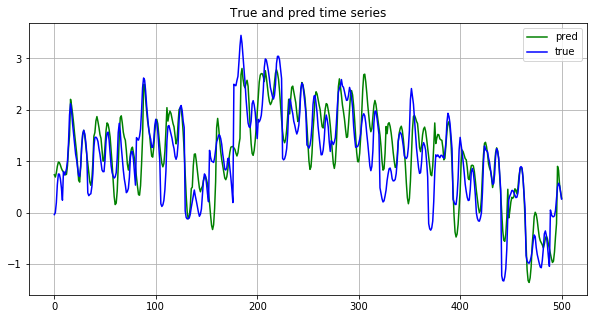

In [476]:
x = np.linspace(0,500,500,dtype=int)
plt.figure(figsize=(10,5))
plt.plot(x, test_predict[:500], 'g-')
plt.plot(x, test_true[:500], 'b-')
plt.title('True and pred time series')
plt.legend(['pred','true'],loc='upper right')
plt.grid()
plt.show()

## Пункт 9

In [478]:
RN2 = Sequential()
RN2.add(GRU(32,
    return_sequences = True,
    input_shape = (None, 1)))
RN2.add(GRU(32, activation = 'relu'))
RN2.add(Dense(1))
RN2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, None, 32)          3360      
_________________________________________________________________
gru_7 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 33        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [480]:
RN2.compile(optimizer=RMSprop(), loss='mae')
history = RN2.fit_generator(train_gen,                 
                             steps_per_epoch=506,    
                             epochs=10,                            
                             validation_data=val_gen,       
                             validation_steps=test_package)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 506 steps, validate for 167 steps
Epoch 1/10
506/506 [==============================] - 103s 204ms/step - loss: 0.3874 - val_loss: 0.3584
Epoch 2/10
506/506 [==============================] - 106s 209ms/step - loss: 0.3384 - val_loss: 0.3180
Epoch 3/10
506/506 [==============================] - 107s 211ms/step - loss: 0.3103 - val_loss: 0.2946
Epoch 4/10
506/506 [==============================] - 108s 213ms/step - loss: 0.2926 - val_loss: 0.2876
Epoch 5/10
506/506 [==============================] - 111s 219ms/step - loss: 0.2758 - val_loss: 0.2646
Epoch 6/10
506/506 [==============================] - 111s 220ms/step - loss: 0.2613 - val_loss: 0.2538
Epoch 7/10
506/506 [==============================] - 113s 223ms/step - loss: 0.2514 - val_loss: 0.2912
Epoch 8/10
506/506 [==============================] - 115s 228ms/step - loss: 0.2442 - val_loss: 0.2438
Epoch 9/10
506/506 [==============================] - 116s 230ms/step - lo

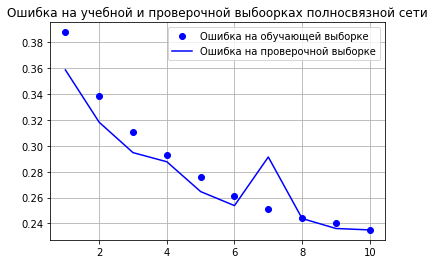

In [481]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Ошибка на обучающей выборке')
plt.grid(True)
plt.plot(epochs, val_loss, 'b', label='Ошибка на проверочной выборке')
plt.title('Ошибка на учебной и проверочной выбоорках полносвязной сети')
plt.legend()
plt.show()

In [495]:
test_predict = RN2.predict_generator(test_gen, test_package)

In [496]:
print(f'ME: {calculate_ME(test_predict, test_true) * std:1.3f}')
print(f'MAE: {calculate_MAE(test_predict, test_true) * std:1.3f}')

ME: 20.437
MAE: 648.370


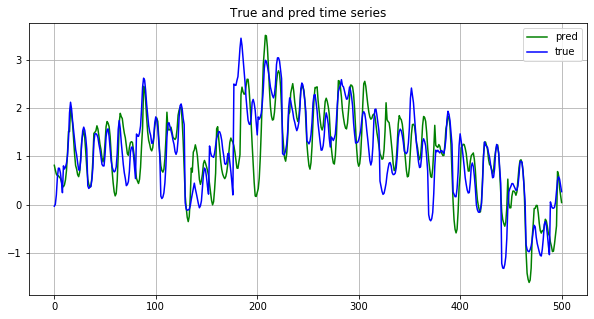

In [497]:
x = np.linspace(0,500,500,dtype=int)
plt.figure(figsize=(10,5))
plt.plot(x, test_predict[:500], 'g-')
plt.plot(x, test_true[:500], 'b-')
plt.title('True and pred time series')
plt.legend(['pred','true'],loc='upper right')
plt.grid()
plt.show()

## Пункт 10

In [498]:
RN3 = Sequential()
RN3.add(GRU(32,
    dropout = 0.1,
    recurrent_dropout = 0.5,
    return_sequences = True,
    input_shape = (None, 1))) 
RN3.add(GRU(32, activation = 'relu', dropout = 0.1,
    recurrent_dropout = 0.5))
RN3.add(Dense(1))
RN3.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, None, 32)          3360      
_________________________________________________________________
gru_9 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 33        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [499]:
RN3.compile(optimizer=RMSprop(), loss='mae')
history = RN3.fit_generator(train_gen,                 
                             steps_per_epoch=500,    
                             epochs=10,                            
                             validation_data=val_gen,       
                             validation_steps=test_package)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 167 steps
Epoch 1/10
500/500 [==============================] - 111s 223ms/step - loss: 0.6318 - val_loss: 0.5237
Epoch 2/10
500/500 [==============================] - 113s 226ms/step - loss: 0.5247 - val_loss: 0.4440
Epoch 3/10
500/500 [==============================] - 118s 237ms/step - loss: 0.4750 - val_loss: 0.4298
Epoch 4/10
500/500 [==============================] - 114s 227ms/step - loss: 0.4474 - val_loss: 0.4008
Epoch 5/10
500/500 [==============================] - 120s 239ms/step - loss: 0.4263 - val_loss: 0.3981
Epoch 6/10
500/500 [==============================] - 113s 225ms/step - loss: 0.4128 - val_loss: 0.3704
Epoch 7/10
500/500 [==============================] - 113s 225ms/step - loss: 0.3988 - val_loss: 0.3969
Epoch 8/10
500/500 [==============================] - 115s 231ms/step - loss: 0.3895 - val_loss: 0.3955
Epoch 9/10
500/500 [==============================] - 116s 232ms/step - lo

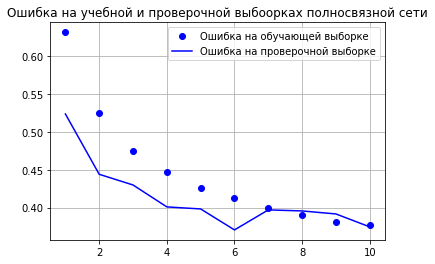

In [500]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Ошибка на обучающей выборке')
plt.grid(True)
plt.plot(epochs, val_loss, 'b', label='Ошибка на проверочной выборке')
plt.title('Ошибка на учебной и проверочной выбоорках полносвязной сети')
plt.legend()
plt.show()

In [506]:
test_predict = RN3.predict_generator(test_gen, test_package)

In [507]:
print(f'ME: {calculate_ME(test_predict, test_true) * std:1.3f}')
print(f'MAE: {calculate_MAE(test_predict, test_true) * std:1.3f}')

ME: 331.787
MAE: 1025.762


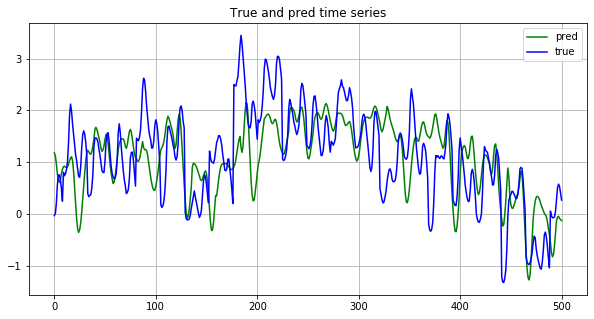

In [508]:
x = np.linspace(0,500,500,dtype=int)
plt.figure(figsize=(10,5))
plt.plot(x, test_predict[:500], 'g-')
plt.plot(x, test_true[:500], 'b-')
plt.title('True and pred time series')
plt.legend(['pred','true'],loc='upper right')
plt.grid()
plt.show()

 - ME   Without ML:   -0.803
 - MAE  Without ML:   2161.788


 - ME   NN:   156.133
 - MAE  NN:   575.663
 
 
 - ME   CNN:  -69.553
 - MAE  CNN:  481.251
 
 
 - ME   RNN:  194.241
 - MAE  RNN:  641.318
 
 
 - ME   RNN2: 20.437
 - MAE  RNN2: 648.370
 
 
 - ME   RNN3: 331.787
 - MAE  RNN3: 1025.762
 
Вывод: реккурентные нейронные сети показали результаты хуже, чем многослойный перцептрон и свёрточная сеть, это подтверждает тот факт, что в данных нет явных трендов и сложных временных зависимостей и нужно только грамотно подходить к выбору алгоритма предварительно, проведя подробный анализ исходных данных.